<center><h1>Szyfr Blowfish</h1><h4>Jan Gołda, WIET 2019</h4></center>

Szyfr [Blowfish](https://pl.wikipedia.org/wiki/Blowfish) jest [szyfrem blokowym](https://pl.wikipedia.org/wiki/Szyfr_blokowy) o blokach rozmiaru **8B** używającym kluczy od **4B** do **56B**.

Ma on postać [szyfru Feistela](https://pl.wikipedia.org/wiki/Sie%C4%87_Feistela) z **16 rundami** z [S-BOX](https://pl.wikipedia.org/wiki/S-Box)ami generowanymi na podstawie klucza.

Generalny proces szyfrowania wygląda następująco:

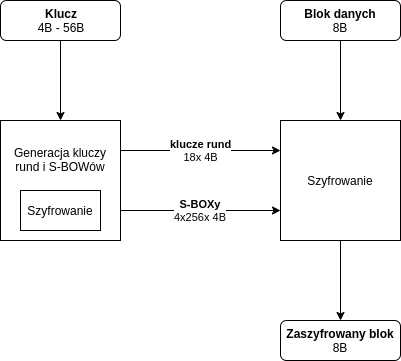

Warto zauważyć, że proces generowania kluczy rund i S-BOXów korzysta wewnętrznie z samego szyfrowania, a zatem implementację całości musimy rozpocząć od procesu szyfrowania mimo, że nie posiadamy jeszcze sposobu na generowanie potrzebnych do tego danych.

---
## 1. Importy i funkcje pomocnicze

In [1]:
from itertools import cycle, islice
from typing import List, Iterable, Generator, Tuple

In [2]:
def group(it: Iterable, n: int, fillvalue: any = None) -> Generator[any, None, None]:
    """ Yields groups of n elements from given iterable. """
    it = iter(it)
    while True:
        ele = []
        try:
            for i in range(n):
                ele.append(next(it))
        except StopIteration:
            if ele:
                yield ele + [fillvalue] * (n - len(ele))
            break
        yield ele

---

## 2. Proces szyfrowania
Proces szyfrowania wygląda jak na schemacie poniżej:

$K_i$ - klucz i-tej rundy (liczone od 0)

$S_i$ - i-ty S-BOX

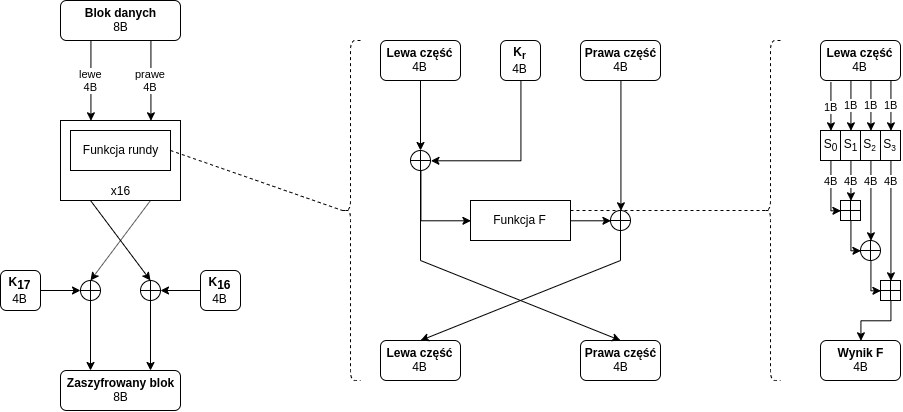



### 2.1. Funkcja F
Jest to główna składowa rundy szyfrowania, która wykorzystuje S-BOXy wg poniższego schematu:
1. Zastosowanie mapowania S-BOXami, gdzie i-ty bajt lewej części jest indeksem dla i-tego S-BOXa
2. Połączenie wyników mapowania przy użuciu XOR oraz dodawania mod $2^{32}$

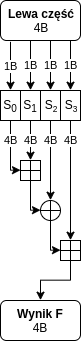



In [3]:
def f_function(left: int, S: List[List[int]]) -> int:
    """
    Aplies the S-BOX mapping and combines results.
    :param left: 4B long left part of block
    :param S: S-Boxes, list of 4x list of 256x 4B long numebrs
    :return: 4B long result of F function
    """
    
    # 1. Apply S-BOX mapping
    results = [
        S[0][(left & 0xff000000 >> 24)],
        S[1][(left & 0x00ff0000 >> 16)],
        S[2][(left & 0x0000ff00 >> 8 )],
        S[3][(left & 0x000000ff >> 0 )]
    ]
    
    # 2. Combine results
    # 2.1
    out = results[0]
    out += results[1]
    out %= 2^32
    # 2.2
    out ^= results[2]
    # 2.3
    out += results[3]
    out %= 2^32
    
    return out

### 2.2. Funkcja rundy
Runda szyfrowania która zostanie powtórzona 16 razy przy każdym szyfrowaniu, korzysta z funkcji F oraz klucza rundy.
1. Zostosowanie XOR dla lewej części wejścia oraz klucza rundy
2. Zastosowanie funkcji F
3. Zastosowanie XOR dla prawej części wejścia i wyniku funkcji F
4. Zamiana części prawej z lewą

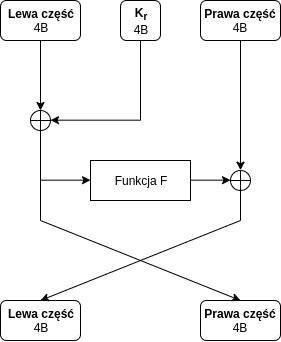



In [4]:
def round_function(left: int, right: int, round_key: int, S: List[List[int]]) -> Tuple[int, int]:
    """
    Applies round function to given input.
    :param left: 4B long left part of block
    :param right: 4B long right part of block
    :param round_key: 4B long key for this round
    :param S: S-Boxes, list of 4x list of 256x 4B long numebrs
    :return: left and right part of block, both 4B long
    """
    
    # 1. Key whitening of the left part of the input with the round key
    left ^= round_key
    
    # 2. Application of F function
    f_result = f_function(left, S)
    
    # 3. Xor of the right part of the input with the output of the F function
    right ^= f_result
    
    # 4. Swapping the parts of the output
    return right, left

### 2.3. Szyfrowanie bloku
Mając funkcję rundy możemy już wykonać całą operację szyfrowania bloku:
1. Podział bloku wejściowego na dwie 4 bajtowe części: lewą i prawą
2. Wykonanie 16 rund szyfrowania (16 pierwszych kluczy rundy)
3. Zamienienie miejscami lewej i prawej części
4. Zastosowanie operacji XOR dla lewej części i klucza rundy 17 (liczone od 0)
5. Zastosowanie operacji XOR dla prawej części i klucza rundy 16 (liczone od 0)
6. Połącznie lewej i prawej części w blok

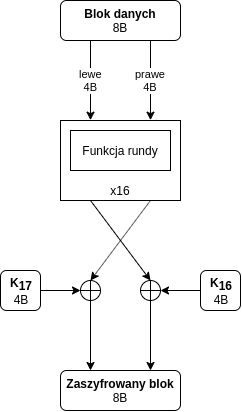



In [5]:
def encrypt_block(block: int, K: List[int], S: List[List[int]]) -> int:
    """
    Encrypts given block using Blowfish cipher.
    :param block: 8B long number
    :param K: round keys, list of 18x 4B long numbers
    :param S: S-Boxes, list of 4x list of 256x 4B long numebrs
    :return: encrypted 8B long number
    """
    
    # 1. Split block into left and right part
    left  = block >> 32
    right = block & 0xffffffff
    
    # 2. Apply 16 rounds of round function
    for i in range(16):
        left, right = round_function(left, right, K[i], S)

    
    # 3. Swapping the parts of the output
    left, right = right, left
    
    # 4. Output whitening by xoring left part with 17th round key
    left ^= K[17]
    
    # 5. Output whitening by xoring right part with 16th round key
    right ^= K[16]

    # 6. Join left and right part
    return (left << 32) + right

### 2.4. Deszyfrowanie bloku
Jako że Blowfish jest szyfrem Feistel'a aby odszyfrować wiadomość należy odwrócić kolejnośc wykonywania rund szyfrowania, a zatem:
1. Podział bloku wejściowego na dwie 4 bajtowe części: lewą i prawą
2. Wykonanie 16 rund szyfrowania (16 **ostatnich** kluczy rundy, wykonywanych **od końca**)
3. Zamienienie miejscami lewej i prawej części
4. Zastosowanie operacji XOR dla lewej części i klucza rundy **0** (liczone od 0)
5. Zastosowanie operacji XOR dla prawej części i klucza rundy **1** (liczone od 0)
6. Połącznie lewej i prawej części w blok

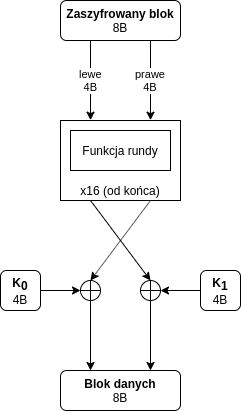



In [6]:
def decrypt_block(block: int, K: List[int], S: List[List[int]]) -> int:
    """
    Decrypts given block using Blowfish cipher.
    :param block: 8B long number
    :param K: round keys, list of 18x 4B long numbers
    :param S: S-Boxes, list of 4x list of 256x 4B long numebrs
    :return: decrypted 8B long number
    """
    
    # 1. Split block into left and right part
    left  = block >> 32
    right = block & 0xffffffff
    
    # 2. Apply 16 rounds of round function in reversed order
    for i in range(17, 1, -1):
        left, right = round_function(left, right, K[i], S)

    
    # 3. Swapping the parts of the output
    left, right = right, left
    
    # 4. Output whitening by xoring left part with 0 round key
    left ^= K[0]
    
    # 5. Output whitening by xoring right part with 1st round key
    right ^= K[1]

    # 6. Join left and right part
    return (left << 32) + right

---
## 3. Proces generowania kluczy rund oraz S-BOXów
Mając już możliwość szyfrowania danych możemy zająć się generowaniem potrzebnych do tego danych na podstawie klucza.



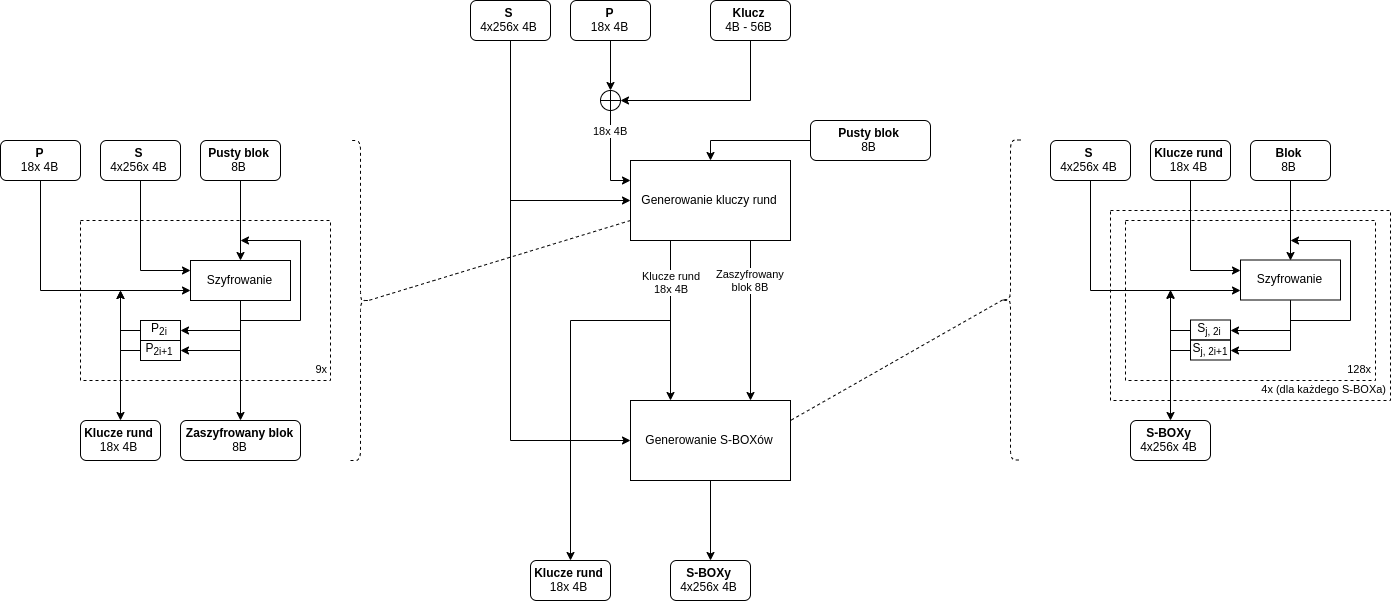

### 3.1 Początkowe wartości
Początkowe wartośći $P$ oraz $S$ są stałe i zdefiniowane jako:

- $P$ - 18 słów (4 bajty każde)
- $S$ - 1024 słów (4 bajty każde, podzielone na 4 bloki po 256 słów)

Których wartości brane są z binarnej reprezentacji części ułamkowej liczby PI.

Jako że daje to w sumie 4168 bajtów wczytamy te wartości z pliku (plik zawiera 1042 4-bajtowe bloki w kodowaniu big-endian):

In [7]:
def get_initial_values(path: str = 'initial.bin') -> Tuple[List[int], List[List[int]]]:
    """ Returns initial values for P and S loaded from file. """
    with open(path, 'rb') as f:
        return (
            [int.from_bytes(f.read(4), byteorder='big') for _ in range(18)],                      # P: 18x 4B
            [[int.from_bytes(f.read(4), byteorder='big') for _ in range(256)]for _ in range(4)]   # S: 4x256x 4B
        )

### 3.2. Generowanie kluczy rund
1. Dziewięciokrotne powtórzenie:
    1. Zaszyfrowanie bloku używając $P$ jako kluczy rund oraz $S$ jako S-BOXów
    2. Zamienienie dwóch kolejnych wartości w $P$ wartościami z zaszyfrowanego bloku
2. Zwrócenie $P$ jako klucze rund

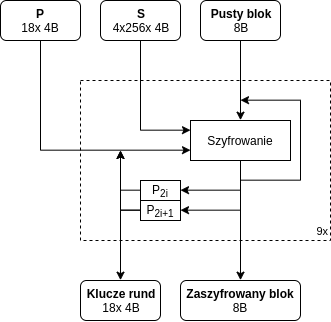

In [8]:
def generate_round_keys(P: List[int], S: List[List[int]], block: int) -> Tuple[List[int], int]:
    """
    Generates round keys from given initial values.
    :param P: initial values of P, list of 18x 4B
    :param S: initial values of S, list of 4x256x 4B
    :param block: empty 8B block
    :returns: tuple (round keys 18x 4B, created 8B block needed for S-BOX generation)
    """
    
    # 1. Repeat 9 times
    for i in range(9):
        
        # 1.A. Encrypt block using P and S
        block = encrypt_block(block, P, S)
        
        # 1.B. Set two next values of P to values from block
        P[2*i] = block >> 32
        P[2*i+1] = block & 0xffffffff

    # 2. Return P as round keys
    return P, block

### 3.3. Generowanie S-BOXów
1. Czterokrotne powtórzenie (dla każdego S-BOXa) oraz 128-krotne wykonanie:
    1. Zaszyfrowanie bloku używając kluczy rund oraz $S$ jako S-BOXów
    2. Zamienienie dwóch kolejnych wartości w danym S-BOXie wartościami z zaszyfrowanego bloku
3. Zwrócenie $S$ jako S-BOXy

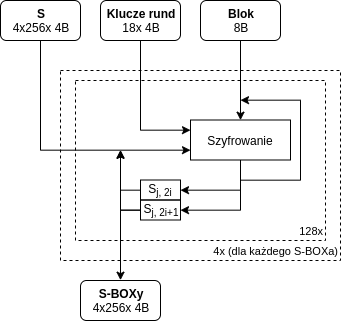

In [9]:
def generate_s_boxes(K: List[int], S: List[List[int]], block: int) -> List[List[int]]:
    """
    Generates S-BOXes from given round keys, initial values S and encrypted block from round keys generation.
    :param L: round keys, list of 18x 4B
    :param S: initial values of S, list of 4x256x 4B
    :param block: encrypted 8B block from round keys generation
    :returns: generated S-BOXes, list of 4x256x 4B
    """
    
    # 1. Repeat for each S-BOX 128 times
    for j in range(4):
        for i in range(128):
            
            # 1.A. Encrypt block using round keys and S
            block = encrypt_block(block, K, S)
            
            # 1.B. Set two next values of current S-BOX to values from block
            S[j][2*i] = block >> 32
            S[j][2*i+1] = block & 0xffffffff
    
    # 2. Returns S as S-BOXes
    return S

### 3.4. Pełny proces generowania kluczy rund i S-BOXów
1. Wczytanie początkowych wartości $P$ i $S$
2. Zastosowanie operacji XOR na P i kluczu. Jako że klucz ma mniejszy rozmiar niż P jest używany cyklicznie.
3. Wygenerowanie kluczy rund używając pustego bloku oraz P i S
4. Wygenerowanie S-BOXów używając kluczy rund, S oraz bloku z poprzedniego kroku

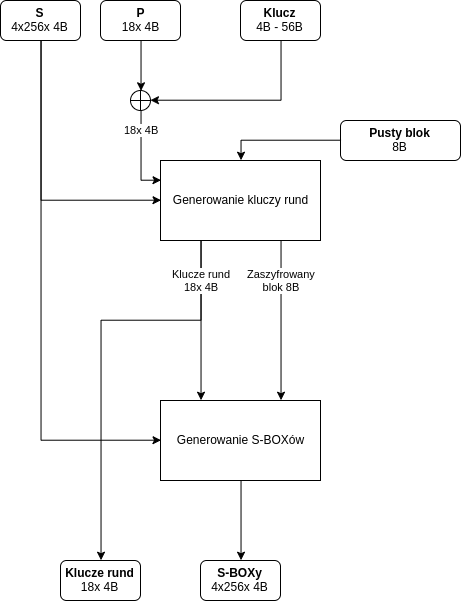

In [10]:
def generate_encryption_parameters(key: bytes) -> Tuple[List[int], List[List[int]]]:
    """
    Generates round keys and S-BOXes using given key.
    :param key: key of size between 4B and 56B
    :returns: tuple (round keys 16x 4B, S-BOXes 4x256x 4B)
    """
    
    # 1. Load initial values for P and S
    P, S = get_initial_values()
    
    # 2. P XOR key
    P = [
        p ^ int.from_bytes(b, 'big')
        for p, b in zip(P, group(cycle(key), 4))
    ]
    
    # 3. Generate round keys
    K, block = generate_round_keys(P, S, 0)
    
    # 4. Generate S-BOXes
    boxes = generate_s_boxes(K, S, block)
    
    return K, boxes

---
## 4. Finalne funkcje szyfrujące i deszyfrujące
Mając już narzędzia pozwalające na generowanie kluczy rund i S-Boxów, oraz funkcję dokonującą samego szyfrowania możemy napisać kod składający wszystko w całość.

### 4.1. Finalne szyfrowanie i deszyfrowanie
Mając już wszystkie potrzebne funkcje możemy stworzyć końcowe funkcje które:
1. Przyjmóją dane w postaci bajtów
2. Weryfikują poprawność danych
3. Generują klucze rund oraz S-Box'y
4. Dzielą dane na 8 bajtowe bloki
5. Szyfrują / Deszyfrują bloki

In [11]:
def encrypt(plainbytes: bytes, key: bytes) -> bytes:
    """
    Encrypts given plain bytes using given key.
    :param plainbytes: bytes to encrypt, must be divisible into 8 bytes blocks
    :param key: key bytes, have to have size in range [4B, 56B]
    :return: encrypted bytes
    """
    
    # 2. Verify size of key
    assert 4 <= len(key) <= 56, 'Key has to have size in range [4B, 56B]'
    assert len(plainbytes) % 8 == 0, 'Bytes to decrypt must be divisible into 8 bytes blocks'
    
    # 3. Generate round keys and S-Blocks
    P, S = generate_encryption_parameters(key)
    
    # 4. Split plain bytes into 8B blocks
    blocks = [
        int.from_bytes(block, byteorder='big') 
        for block in group(plainbytes, 8)
    ]
    
    # 5. Cipher plain bytes block by block
    cipherbytes = b''.join(
        int.to_bytes(encrypt_block(block, P, S), 8, byteorder='big') 
        for block in blocks
    )
    
    return cipherbytes

def decrypt(cipherbytes: bytes, key: bytes) -> bytes:
    """
    Decrypts given plain bytes using given key.
    :param cipherbytes: bytes to decrypt, must be divisible into 8 bytes blocks
    :param key: key bytes, have to have size in range [4B, 56B]
    :return: decrypted bytes
    """
    
    # 2. Verify size of key and cipherbytes
    assert 4 <= len(key) <= 56, 'Key has to have size in range [4B, 56B]'
    assert len(cipherbytes) % 8 == 0, 'Bytes to decrypt must be divisible into 8 bytes blocks'
    
    # 3. Generate round keys and S-Blocks
    P, S = generate_encryption_parameters(key)
    
    # 4. Split cipher bytes into 8B blocks
    blocks = [
        int.from_bytes(block, byteorder='big') 
        for block in group(cipherbytes, 8)
    ]
    
    # 5. Decipher cipher bytes block by block
    plainbytes = b''.join(
        int.to_bytes(decrypt_block(block, P, S), 8, byteorder='big') 
        for block in blocks
    )
    
    return plainbytes

### 4.2. Szyfrowanie i deszyfrowanie tekstu
Aby móc wygodnie testować ten szyfr stworzymy pomocnicze funkcje, które pozwalają przekazać dane oraz klucz w postaci tekstu zamiast bajtów.

Jako że Blowfish pracuje na 8B blokach przy szyfrowaniu musimy dopełnić tekst pustymi znakami do wielokrotności 8, a przy deszyfrowaniu je usunąć.

In [12]:
def encrypt_str(plaintext: str, key: str, encoding: str = 'utf-8') -> bytes:
    """ Encrypts given plain text using given key. """
    if len(plaintext) % 8:
        plaintext += '\x00' * (8 - len(plaintext) % 8)
    
    return encrypt(bytes(plaintext, encoding), bytes(key, encoding))

def decrypt_str(cipherbytes: bytes, key: str, encoding='utf-8'):
    """ Decrypts given plain text using given key. """
    return decrypt(cipherbytes, bytes(key, encoding)).decode(encoding).replace('\x00', '')

---
## 5. Przykłady

### 5.1. Szyfrowanie bloków

In [13]:
# Encryption
encrypt_block(12345678, *generate_encryption_parameters(b'key-key'))

6793591723558030277

In [14]:
# ERROR - wrong key
decrypt_block(6793591723558030277, *generate_encryption_parameters(b'not-not'))

936748907222493559

In [15]:
# OK
decrypt_block(6793591723558030277, *generate_encryption_parameters(b'key-key'))

12345678

### 5.2. Szyfrowanie bajtów

In [16]:
# Encryption
encrypt(b'testtest', b'key-key')

b'*\x9e\xbd\x9d\xc3\xd0\xb8\x81'

In [17]:
# ERROR - wrong key
decrypt(b'*\x9e\xbd\x9d\xc3\xd0\xb8\x81', b'not-not')

b'yesVvb{u'

In [18]:
# OK
decrypt(b'*\x9e\xbd\x9d\xc3\xd0\xb8\x81', b'key-key')

b'testtest'

### 5.3. Szyfrowanie tekstu

In [19]:
# Encryption
encrypt_str('ala ma kota', 'klucz')

b'/\xc0\xba\xb4\xcc\x89\xf2\xa3B\xa1\x9a\xc7\xc2\x91\xf2\xac'

In [20]:
# ERROR - wrong key
decrypt_str(b'/\xc0\xba\xb4\xcc\x89\xf2\xa3B\xa1\x9a\xc7\xc2\x91\xf2\xac', 'nie-klucz')

'\'n}\x06f"0;)v}\x1f\x0bC\x10F'

In [21]:
# OK
decrypt_str(b'/\xc0\xba\xb4\xcc\x89\xf2\xa3B\xa1\x9a\xc7\xc2\x91\xf2\xac', 'klucz')

'ala ma kota'